## **Table of Contents**

---

* [Exploratory Data Analysis](#Exploratory-Data-Analysis)

    * [Image Distribution](#Image-Distribution)

    * [Image Count](#Image-Count)

    * [Class Visualization](#Class-Visualization)

* [Image Preprocessing](#Image-Preprocessing)

     * [Image Resize](#Image-Resize)

     * [Datasets](#Datasets)

* [Model](#Model)

     * [Data Augmentation](#Data-Augmentation)

     * [Callbacks](#Callbacks)

     * [Base Model](#Base-Model)

     * [Base Model Performance](#Base-Model-Performance)

     * [Fine-Tuned Model](#Fine-Tuned-Model)

     * [Fine-Tuned Model Performance](#Fine-Tuned-Model-Performance)

* [Evaluation](#Evaluation)

     * [Accuracy](#Accuracy)

     * [Precision, Recall & F1](#Precision-Recall-F1)

     * [Confusion Matrix](#Confusion-Matrix)

In [ ]:
pip install split-folders squarify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importing required libraries

import matplotlib.pyplot as plt

import os

import numpy as np

import tensorflow as tf

import pandas as pd

import random

import splitfolders

import cv2

import glob

import csv

from tensorflow.keras.preprocessing import image

from tensorflow.keras import layers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *

import squarify

import seaborn as sns

from sklearn.metrics import classification_report

In [ ]:
# Setting plot style

plt.style.use('ggplot')

In [ ]:
# Install required packages
!pip install --quiet google-auth-oauthlib google-auth-httplib2 google-api-python-client

from google.colab import auth
from google.colab import drive
import os
import io
import pickle
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from tqdm.notebook import tqdm
import shutil
import splitfolders

# Authenticate and create the Drive API client
auth.authenticate_user()
drive_service = build('drive', 'v3')

def list_folder_contents(folder_id):
    """List all files in a folder."""
    results = []
    page_token = None

    while True:
        try:
            query = f"'{folder_id}' in parents"
            response = drive_service.files().list(
                q=query,
                spaces='drive',
                fields='nextPageToken, files(id, name, mimeType)',
                pageToken=page_token
            ).execute()

            results.extend(response.get('files', []))
            page_token = response.get('nextPageToken')

            if not page_token:
                break

        except Exception as e:
            print(f"An error occurred: {e}")
            break

    return results

def download_file(file_id, destination):
    """Download a file from Drive."""
    try:
        request = drive_service.files().get_media(fileId=file_id)
        fh = io.BytesIO()
        downloader = MediaIoBaseDownload(fh, request)
        done = False

        while done is False:
            status, done = downloader.next_chunk()

        fh.seek(0)
        with open(destination, 'wb') as f:
            f.write(fh.read())
            f.close()

        return True
    except Exception as e:
        print(f"Error downloading file: {e}")
        return False

def download_folder(folder_id, destination_path):
    """Download all files from a folder."""
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)

    items = list_folder_contents(folder_id)
    print(f"Found {len(items)} items in folder")

    # Process each item
    for item in tqdm(items, desc="Downloading files"):
        if item['mimeType'] == 'application/vnd.google-apps.folder':
            # Create subfolder and download its contents
            subfolder_path = os.path.join(destination_path, item['name'])
            os.makedirs(subfolder_path, exist_ok=True)
            download_folder(item['id'], subfolder_path)
        else:
            # Download file
            file_path = os.path.join(destination_path, item['name'])
            download_file(item['id'], file_path)

# Set up paths
FOLDER_ID = "1pDX__dOz0MwVFr388rjSA45jg1_y5EH1"  # Your folder ID
LOCAL_DOWNLOAD_PATH = "chess_data"
DESTINATION_PATH = "Data"

# Create directories
os.makedirs(LOCAL_DOWNLOAD_PATH, exist_ok=True)
os.makedirs(DESTINATION_PATH, exist_ok=True)

print("Downloading chess dataset...")
download_folder(FOLDER_ID, LOCAL_DOWNLOAD_PATH)

def organize_chess_dataset(source_path, destination_path):
    """Organizes the chess dataset into a structured format."""
    # Create Raw Dataset directory
    raw_dataset_path = os.path.join(destination_path, "Raw Dataset")
    os.makedirs(raw_dataset_path, exist_ok=True)

    # List of chess pieces to process
    chess_pieces = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

    # Create directories for each chess piece (in lowercase)
    for piece in chess_pieces:
        piece_dir = os.path.join(raw_dataset_path, piece.lower())
        os.makedirs(piece_dir, exist_ok=True)

    print(f"Source path: {source_path}")
    files_copied = 0

    # Create progress bar for processing
    pbar = tqdm(chess_pieces, desc="Processing chess pieces")

    # Copy files from each piece directory
    for piece in pbar:
        # Try different possible path combinations
        possible_paths = [
            os.path.join(source_path, piece),
            os.path.join(source_path, piece.lower()),
            os.path.join(source_path, "chess", piece),
            os.path.join(source_path, "Chess", piece)
        ]

        source_piece_dir = None
        for path in possible_paths:
            if os.path.exists(path):
                source_piece_dir = path
                break

        if source_piece_dir:
            pbar.set_description(f"Processing {piece}")
            files = [f for f in os.listdir(source_piece_dir)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

            file_pbar = tqdm(files, desc=f"Copying {piece} files", leave=False)
            for file in file_pbar:
                source_file = os.path.join(source_piece_dir, file)
                dest_file = os.path.join(raw_dataset_path, piece.lower(), file)
                shutil.copy2(source_file, dest_file)
                files_copied += 1
        else:
            print(f"\nWarning: Could not find directory for {piece}")
            print(f"Tried paths: {possible_paths}")

    print(f"\nTotal files copied: {files_copied}")
    return raw_dataset_path

def count_files_in_dir(directory):
    """Counts image files in a directory and its subdirectories."""
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))])
    return total

# Print the structure of the downloaded directory
print("\nChecking downloaded directory structure:")
for root, dirs, files in os.walk(LOCAL_DOWNLOAD_PATH):
    level = root.replace(LOCAL_DOWNLOAD_PATH, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:  # Show only first 5 files per directory
        print(f"{subindent}{f}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")

# Process the dataset
print("\nStarting dataset organization...")
raw_dataset_path = organize_chess_dataset(LOCAL_DOWNLOAD_PATH, DESTINATION_PATH)

# Verify organization
print("\nContents of organized directories:")
for piece in ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']:
    piece_dir = os.path.join(raw_dataset_path, piece)
    if os.path.exists(piece_dir):
        file_count = len(os.listdir(piece_dir))
        print(f"{piece}: {file_count} images")

# Split dataset
print("\nSplitting dataset...")
preprocessed_path = os.path.join(DESTINATION_PATH, "Preprocessed Dataset")
splitfolders.ratio(raw_dataset_path,
                  output=preprocessed_path,
                  seed=42,
                  ratio=(.7, .2, .1),
                  group_prefix=None,
                  move=False)

# Verify final structure
print("\nFinal dataset structure and file counts:")
splits = ['train', 'val', 'test']
for split in splits:
    split_dir = os.path.join(preprocessed_path, split)
    total_files = count_files_in_dir(split_dir)
    print(f"\n{split}: {total_files} total images")
    for piece in ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']:
        piece_dir = os.path.join(split_dir, piece)
        if os.path.exists(piece_dir):
            file_count = len(os.listdir(piece_dir))
            print(f" {piece}: {file_count} images")

Starting dataset organization...
Source path: /kaggle/input/chessman-image-dataset/Chessman-image-dataset/Chess
Processing Bishop directory...
Copied 50 files...
Processing King directory...
Copied 100 files...
Copied 150 files...
Processing Knight directory...
Copied 200 files...
Copied 250 files...
Processing Pawn directory...
Copied 300 files...
Copied 350 files...
Processing Queen directory...
Copied 400 files...
Processing Rook directory...
Copied 450 files...
Copied 500 files...
Copied 550 files...
Total files copied: 551

Contents of organized directories:
bishop: 86 images
king: 75 images
knight: 105 images
pawn: 106 images
queen: 77 images
rook: 102 images

Splitting dataset...


Copying files: 551 files [00:00, 3660.75 files/s]


Final dataset structure and file counts:

train: 383 total images
  bishop: 60 images
  king: 52 images
  knight: 73 images
  pawn: 74 images
  queen: 53 images
  rook: 71 images

val: 109 total images
  bishop: 17 images
  king: 15 images
  knight: 21 images
  pawn: 21 images
  queen: 15 images
  rook: 20 images

test: 59 total images
  bishop: 9 images
  king: 8 images
  knight: 11 images
  pawn: 11 images
  queen: 9 images
  rook: 11 images


## **Exploratory Data Analysis**

---

### Image Distribution

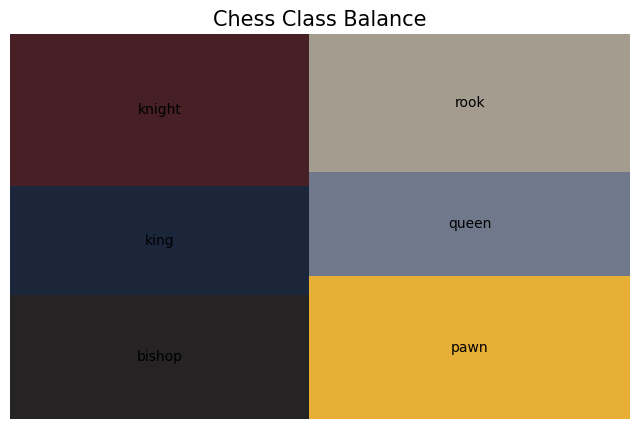

In [ ]:
# The directory where raw dataset is located

raw_images_dir = "Data/Raw Dataset"



# All the class names in the correct order

class_names = ["bishop", "king", "knight", "pawn", "queen", "rook"]



# Get the number of images for each class

image_counts = [len(os.listdir(os.path.join(raw_images_dir, class_name))) for class_name in class_names]



# Create a squarify plot of the class distribution

fig, ax = plt.subplots(figsize = (8, 5))



colors = ["#252323", "#1B263B", "#462025", "#E7AF36", "#70798C", "#A39C8F"]

squarify.plot(image_counts, label = class_names, ax = ax, text_kwargs = {"fontsize": 10}, color = colors)



plt.title("Chess Class Balance", fontsize = 15)

plt.axis("off");

### Image Count

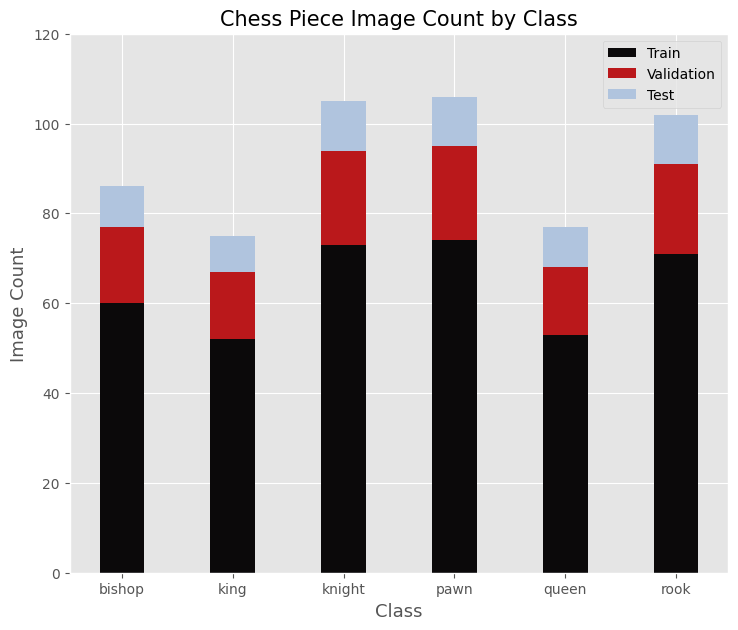

In [ ]:
# The directory where preprocessed dataset is located

pre_images_dir = 'Data/Preprocessed Dataset'



# Calculate the number of images in each class for train, validation, and test sets

train_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "train", class_name))) for class_name in class_names]

val_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "val", class_name))) for class_name in class_names]

test_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "test", class_name))) for class_name in class_names]



# Convert the image count lists to numpy arrays

train_image_counts = np.array(train_image_counts)

val_image_counts = np.array(val_image_counts)

test_image_counts = np.array(test_image_counts)



# Create a bar plot of image counts for each class in each dataset split

fig, ax = plt.subplots(figsize = (8.5, 7))



ax.bar(class_names, train_image_counts, width = 0.4, label = "Train", color = "#0b090a")

ax.bar(class_names, val_image_counts, width = 0.4, label = "Validation", bottom = train_image_counts, color = "#ba181b")

ax.bar(class_names, test_image_counts, width = 0.4, label = "Test", bottom = train_image_counts + val_image_counts, color="#b0c4de")



# Set the y-axis limit and add labels for the x and y axes

ax.set_ylim(0, 120)

plt.ylabel("Image Count", fontsize = 13)

plt.xlabel("Class", fontsize = 13)

plt.title("Chess Piece Image Count by Class", fontsize = 15)

ax.legend();

### Class Visualization

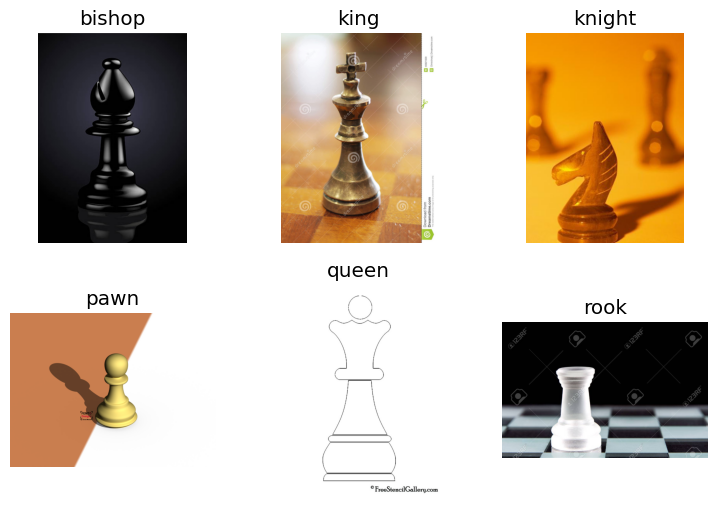

In [ ]:
# Images are loaded from the Raw Dataset directory

images = []



# Loop through all class names and pick a random image for each class

for class_name in class_names:

    image_files = os.listdir(os.path.join(raw_images_dir, class_name))

    image_file = random.choice(image_files)

    images.append(os.path.join(raw_images_dir, class_name, image_file))



# Loop through all the images and display them in the subplot

fig, ax = plt.subplots(2, 3, figsize = (9, 6))



for i in range(6):

    ax[i // 3, i % 3].imshow(plt.imread(images[i]))

    ax[i // 3, i % 3].set(title = class_names[i])

    ax[i//3, i%3].axis('off');

## **Image Preprocessing**

---

### Image Resize

In [ ]:
# Get a list of directories (train, val, test) in preprocessed dataset

main_directories = os.listdir(pre_images_dir)



# Loop through each main directory and get a list of sub-directories (class folders) in it

for main_directory in main_directories:

    main_directory_path = os.path.join(pre_images_dir, main_directory)

    sub_directories = os.listdir(main_directory_path)



    # Loop through each sub-directory (class) and get a list of all image paths

    for sub_directory in sub_directories:

        sub_directory_path = os.path.join(main_directory_path, sub_directory)

        image_paths = glob.glob(os.path.join(sub_directory_path, '*jpg'))



        # Loop through each image path and resize it

        for image_path in image_paths:

            img = cv2.imread(image_path)

            img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_CUBIC)

            img = img.astype(np.float32)

            cv2.imwrite(image_path, img)

### Datasets

In [ ]:
# Load the training dataset

train_data = tf.keras.preprocessing.image_dataset_from_directory('Data/Preprocessed Dataset/train',

                                                                 label_mode = "categorical",

                                                                 image_size = (224, 224) ,

                                                                 seed = 42)

Found 383 files belonging to 6 classes.


In [ ]:
# Load the validation dataset

val_data = tf.keras.preprocessing.image_dataset_from_directory('Data/Preprocessed Dataset/val',

                                                                label_mode = "categorical",

                                                                image_size = (224, 224),

                                                                seed = 42)

Found 109 files belonging to 6 classes.


In [ ]:
# Load the test dataset

test_data = tf.keras.preprocessing.image_dataset_from_directory('Data/Preprocessed Dataset/test',

                                                                label_mode = "categorical",

                                                                image_size = (224, 224),

                                                                seed = 42,

                                                                shuffle = False)

Found 59 files belonging to 6 classes.


## **Model**

---

### Data Augmentation

In [ ]:
from tensorflow.keras import Sequential

from tensorflow.keras.layers import (

    RandomFlip,

    RandomRotation,

    RandomHeight,

    RandomWidth,

    RandomZoom

)



# Data Augmentation layer

data_augmentation = Sequential([

    RandomFlip('horizontal', seed=42),

    RandomRotation(0.2, seed=42),

    RandomHeight(0.2, seed=42),

    RandomWidth(0.2, seed=42),

    RandomZoom(0.2, seed=42)

])

In [ ]:
# from tensorflow.keras import Sequential

# from tensorflow.keras.layers import (

#     RandomFlip,

#     RandomRotation,

#     RandomHeight,

#     RandomWidth,

#     RandomZoom

# )

# # Enhanced Data Augmentation
# data_augmentation = Sequential([
#     RandomFlip('horizontal_and_vertical', seed=42),
#     RandomRotation(0.3, seed=42),
#     RandomHeight(0.3, seed=42),
#     RandomWidth(0.3, seed=42),
#     RandomZoom(0.3, seed=42),
#     RandomContrast(0.2, seed=42),  # Add contrast variation
#     RandomBrightness(0.2, seed=42)  # Add brightness variation
# ])

### Callbacks

In [ ]:
# Callback to save the best model based on validation accuracy during training

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('Data/Checkpoint.keras',

                                                      save_best_only = True,

                                                      monitor = "val_accuracy")



# Callback to reduce the learning rate when the validation accuracy stops improving

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_accuracy",

                                                 factor = 0.2,

                                                 patience = 3,

                                                 min_lr = 1e-7)



# Callback to log training history to a csv file

base_csv_logger = tf.keras.callbacks.CSVLogger('Data/Base Model History.csv')

ft_csv_logger = tf.keras.callbacks.CSVLogger('Data/Fine-Tuned Model History.csv')

### Base Model

In [ ]:
# Base Model

base_model = tf.keras.applications.VGG19(include_top=False)

base_model.trainable = False



inputs = tf.keras.Input(shape=(224, 224, 3))



# Fix the data flow: Change base_model(inputs) to base_model(x)

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

x = base_model(x)  # Changed from base_model(inputs)

x = layers.Dropout(0.4)(x)



x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

x = layers.Dropout(0.5)(x)



x = tf.keras.layers.GlobalMaxPooling2D()(x)

x = layers.Dropout(0.6)(x)



x = layers.Dense(6)(x)

outputs = layers.Activation("softmax")(x)



# Create the model

model = tf.keras.Model(inputs, outputs)

In [ ]:
# # Enhanced Model Architecture
# base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
# base_model.trainable = False

# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)

# # Pass through base model
# x = base_model(x)

# # Add more complex top layers
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.4)(x)

# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.4)(x)

# x = tf.keras.layers.GlobalMaxPooling2D()(x)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(6)(x)
# outputs = layers.Activation("softmax")(x)

# model = tf.keras.Model(inputs, outputs)

In [ ]:
# # Learning rate schedule
# initial_learning_rate = 0.001
# decay_steps = 1000
# decay_rate = 0.9
# learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps, decay_rate
# )

# # Modified optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# # Compile with the new optimizer
# model.compile(
#     optimizer=optimizer,
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

In [ ]:
# # First phase: Train the top layers
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Train for initial epochs
# history1 = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=15,
#     callbacks=[model_checkpoint, reduce_lr, base_csv_logger]
# )

# # Second phase: Fine-tuning
# # Unfreeze the last 15 layers of the base model
# base_model.trainable = True
# for layer in base_model.layers[:-15]:
#     layer.trainable = False

# # Recompile with a very low learning rate
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Continue training
# history2 = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=20,
#     callbacks=[model_checkpoint, reduce_lr, ft_csv_logger]
# )

Found 383 files belonging to 6 classes.
Found 109 files belonging to 6 classes.
Epoch 1/25


2024-11-11 22:20:10.755867: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_12_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.1671 - loss: 3.9889 - val_accuracy: 0.2477 - val_loss: 1.7719 - learning_rate: 0.0010
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.1784 - loss: 1.9097 - val_accuracy: 0.2752 - val_loss: 1.7493 - learning_rate: 0.0010
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.2496 - loss: 1.7797 - val_accuracy: 0.3853 - val_loss: 1.6546 - learning_rate: 0.0010
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.3191 - loss: 1.6360 - val_accuracy: 0.3853 - val_loss: 1.5058 - learning_rate: 0.0010
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.3887 - loss: 1.4891 - val_accuracy: 0.5321 - val_loss: 1.3177 - learning_rate: 0.0010
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4639 - loss: 1.3366 - val_accuracy: 0.5505 - val_loss: 1.1378 - learning_rate: 0.0010
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.5027 - loss: 1.2825 - val_accurac

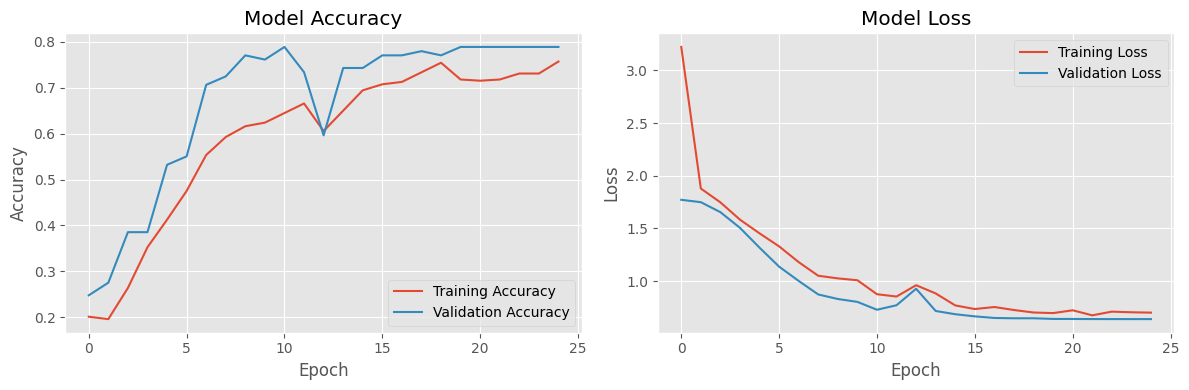

In [ ]:
# 1. First, modify your dataset creation

BATCH_SIZE = 32

IMG_SIZE = (224, 224)



# Load and configure the training dataset

train_data = tf.keras.preprocessing.image_dataset_from_directory(

    'Data/Preprocessed Dataset/train',

    label_mode="categorical",

    image_size=IMG_SIZE,

    batch_size=BATCH_SIZE,

    seed=42

)



# Load and configure the validation dataset

val_data = tf.keras.preprocessing.image_dataset_from_directory(

    'Data/Preprocessed Dataset/val',

    label_mode="categorical",

    image_size=IMG_SIZE,

    batch_size=BATCH_SIZE,

    seed=42

)



# Configure dataset performance

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)

val_data = val_data.prefetch(buffer_size=AUTOTUNE)



# 2. Define preprocessing function

def preprocess_input(image, label):

    image = tf.cast(image, tf.float32) / 255.0

    return image, label



# Apply preprocessing to datasets

train_data = train_data.map(preprocess_input)

val_data = val_data.map(preprocess_input)



# 3. Model Definition

base_model = tf.keras.applications.VGG19(include_top=False)

base_model.trainable = False



inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)

x = base_model(x)

x = layers.Dropout(0.4)(x)



x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

x = layers.Dropout(0.5)(x)



x = tf.keras.layers.GlobalMaxPooling2D()(x)

x = layers.Dropout(0.6)(x)



x = layers.Dense(6)(x)

outputs = layers.Activation("softmax")(x)



model = tf.keras.Model(inputs, outputs)



# 4. Compile the model

model.compile(

    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),

    loss="categorical_crossentropy",

    metrics=["accuracy"]

)



# 5. Train the model

history = model.fit(

    train_data,

    validation_data=val_data,

    epochs=25,

    callbacks=[model_checkpoint, reduce_lr, base_csv_logger]

)



# 6. Plot training history

plt.figure(figsize=(12, 4))



plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend()



plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()



plt.tight_layout()

plt.show()

### Base Model Performance

### Fine Tuned Model

In [ ]:
# Unfreezing the base model entirely

base_model.trainable = True



# Freezing all layers in the base model, except the last 10 layers

for layer in base_model.layers[:-10]:

  layer.trainable = False



# Compiling the model

model.compile(loss = "categorical_crossentropy",

              optimizer = tf.keras.optimizers.Adam(learning_rate = 2.0000e-05),

              metrics = ["accuracy"])

In [ ]:
# 5. Train the model

history = model.fit(

    train_data,

    validation_data=val_data,

    epochs=25,

    callbacks=[model_checkpoint, reduce_lr, base_csv_logger]

)

Epoch 1/25


2024-11-11 22:21:14.414611: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_12_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.6735 - loss: 0.8222 - val_accuracy: 0.7706 - val_loss: 0.6304 - learning_rate: 2.0000e-05
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.7947 - loss: 0.6251 - val_accuracy: 0.8440 - val_loss: 0.5701 - learning_rate: 2.0000e-05
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7790 - loss: 0.5554 - val_accuracy: 0.8349 - val_loss: 0.5939 - learning_rate: 2.0000e-05
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.7386 - loss: 0.5981 - val_accuracy: 0.7890 - val_loss: 0.6220 - learning_rate: 2.0000e-05
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8155 - loss: 0.5207 - val_accuracy: 0.8257 - val_loss: 0.5283 - learning_rate: 2.0000e-05
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.8493 - loss: 0.4382 - val_accuracy: 0.8073 - val_loss: 0.5139 - learning_rate: 4.0000e-06
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.8087 - lo

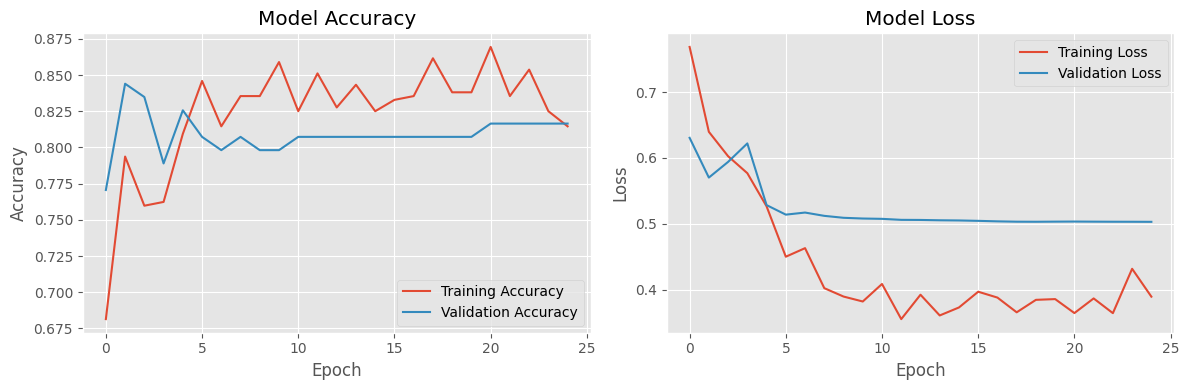

In [ ]:
# 6. Plot training history

plt.figure(figsize=(12, 4))



plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend()



plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()



plt.tight_layout()

plt.show()

### Fine Tuned Model Performance

## **Evaluation**

---

In [ ]:
# Load the weights

model.load_weights('Data/Checkpoint.keras')

### Accuracy

In [ ]:
# Calculating the accuracy of the model on the test dataset

accuracy = model.evaluate(test_data)[1] * 100

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7811 - loss: 12.3747


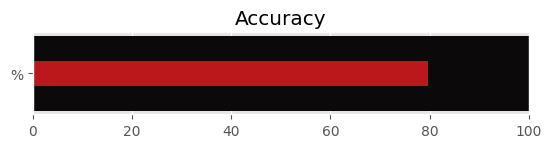

In [ ]:
# Plot a horizontal bar plot to represent accuracy

fig, ax = plt.subplots()



ax.barh([1], 100, left = 0, height = 15, color="#0B090A")

ax.barh([1], accuracy, color="#BA181B", height = 5);



ax.set_aspect('equal')

ax.set_yticks([1])

ax.set_yticklabels('%')

ax.set_xlim(0, 100)

ax.set(title = 'Accuracy');

### Precision, Recall & F1

In [ ]:
# Predictions the test data

test_pred = model.predict(test_data)



# Getting the highest probabilty prediction

test_pred = np.argmax(test_pred, axis=1)



# Creating an empty list to store the true labels

test_true = []



for images, labels in test_data.unbatch():

  test_true.append(labels.numpy().argmax())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


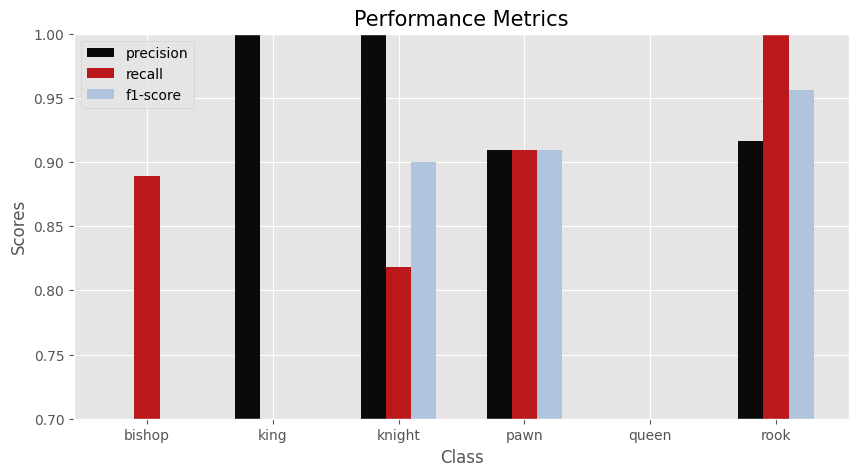

In [ ]:
# Calculate the classification report

report = classification_report(test_true, test_pred, output_dict=True)



# Define the metrics to use

metrics = ["precision", "recall", "f1-score"]



# Initialize a list to store the scores for each class

class_scores = []



for i in range(6):

    class_scores.append([report[str(i)][metric] for metric in metrics])



# Plot the data

fig, ax = plt.subplots(figsize = (10, 5))



bar_width = 0.2

for i, scores in enumerate(class_scores):

    ax.bar(i - bar_width, scores[0], bar_width, color="#0b090a")

    ax.bar(i, scores[1], bar_width, color="#ba181b")

    ax.bar(i + bar_width, scores[2], bar_width, color="#b0c4de")



ax.set_xlabel("Class")

ax.set_ylabel("Scores")

ax.set_ylim(0.7, 1)

ax.legend(metrics)

ax.set_xticks([0, 1, 2, 3, 4, 5])

ax.set_xticklabels(class_names)

ax.set_title("Performance Metrics", fontsize = 15);

### Confusion Matrix

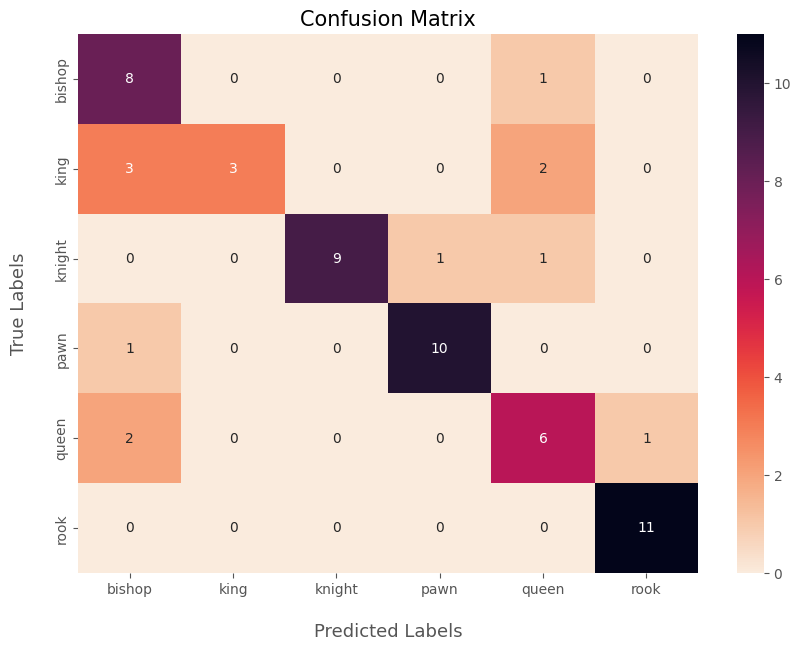

In [ ]:
# Calculate the confusion matrix

cm = tf.math.confusion_matrix(test_true, test_pred)



# Plot the confusion matrix

fig, ax = plt.subplots(figsize=(10, 7))



sns.heatmap(cm, annot=True, fmt='', ax = ax, cmap = 'rocket_r')



ax.set_yticklabels(class_names, va="center")

ax.set_xticklabels(class_names, ha="center")

ax.set_xlabel('\nPredicted Labels', fontsize = 13)

ax.set_ylabel('True Labels\n', fontsize = 13)



plt.title("Confusion Matrix", fontsize = 15);